In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import keras.backend as K
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential

In [5]:
path_train='orchid-genus/train'
path_test='orchid-genus/test'
categories  = ['cattleya', 'dendrobium', 'oncidium', 'phalaenopsis', 'vanda']

In [6]:
import os
import cv2
import random
import numpy as np

img_size = 128
def create_data_img(folder_path):
    imageData = []
    for category in categories:
        path = os.path.join(folder_path, category)
        class_num = categories.index(category) # Take the Label as the Index
        for img in os.listdir(path):
            img_array   = cv2.imread(os.path.join(path, img)) 
            img_convert = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_resize  = cv2.resize(img_convert, (img_size, img_size))
            imageData.append([img_resize, class_num])
    
    return imageData

dataTrain   = create_data_img(path_train)
dataTest    = create_data_img(path_test)
random.seed(120) # 120 so we can know if we want to test again this particular case
random.shuffle(dataTrain)

In [7]:
print("Train Cattleya:", len(os.listdir('orchid-genus/train/cattleya')))
print("Train Dendrobium:", len(os.listdir('orchid-genus/train/dendrobium')))
print("Train Oncidium:", len(os.listdir('orchid-genus/train/oncidium')))
print("Train Phalaenopsis:", len(os.listdir('orchid-genus/train/phalaenopsis')))
print("Train Vanda:", len(os.listdir('orchid-genus/train/vanda')))


Train Cattleya: 800
Train Dendrobium: 800
Train Oncidium: 800
Train Phalaenopsis: 800
Train Vanda: 800


In [8]:
print("Test Cattleya:", len(os.listdir('orchid-genus/test/cattleya')))
print("Test Dendrobium:", len(os.listdir('orchid-genus/test/dendrobium')))
print("Test Oncidium:", len(os.listdir('orchid-genus/test/oncidium')))
print("Test Phalaenopsis:", len(os.listdir('orchid-genus/test/phalaenopsis')))
print("Test Vanda:", len(os.listdir('orchid-genus/test/vanda')))

Test Cattleya: 500
Test Dendrobium: 500
Test Oncidium: 500
Test Phalaenopsis: 500
Test Vanda: 500


In [9]:
# X for Features & y for Labels
X_train, y_train, X_test, y_test = [], [], [], []

for features, label in dataTrain:
    X_train.append(features)
    y_train.append(label)

for features, label in dataTest:
    X_test.append(features)
    y_test.append(label)

# -1 in reshape, means to let Numpy define the appropriate data dimensions
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.asarray(y_train)
X_test  = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test  = np.asarray(y_test)

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)

X_train : (4000, 128, 128, 3)
y_train : (4000,)
X_test  : (2500, 128, 128, 3)
y_test  : (2500,)


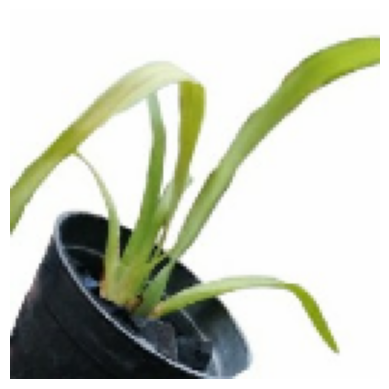

In [10]:
plt.axis("off")
plt.imshow(X_train[52])

In [11]:
print("Array of X_train :\n\n", X_train[0]) # Take the first data for example
print("\nArray of X_test  :\n\n", X_test[0])

def prep_pixels(train, test):
    # Convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Normalize (feature scaling) to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # Return normalized images
    return train_norm, test_norm

X_train_norm, X_test_norm = prep_pixels(X_train, X_test)

print("\nArray of X_train_norm :\n\n", X_train_norm[0])
print("\nArray of X_test_norm  :\n\n", X_test_norm[0])

Array of X_train :

 [[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]]

Array of X_test  :

 [[[210 199 171]
  [202 193 166]
  [194 188 164]
  ...
  [113  98  83]
  [119 112  98]
  [178 177 162]]

 [[215 205 178]
  [198 191 166]
  [191 185 162]
  ...
  [205 196 186]
  [201 198 190]
  [203 203 196]]

 [[216 209 183]
  [210 204 181]
  [204 198 178]
  ...
  [199 197 197]
  [200 200 201]
  [196 197 199]]

 ...

 [[ 99 10

In [12]:
vanda="orchid-genus/test/vanda"
vanda_files = os.listdir(vanda)

phalaenopsis="orchid-genus/test/phalaenopsis"
phalaenopsis_files = os.listdir(phalaenopsis)

oncidium="orchid-genus/test/oncidium"
oncidium_files = os.listdir(oncidium)

dendrobium="orchid-genus/test/dendrobium"
dendrobium_files= os.listdir(dendrobium)

cattleya="orchid-genus/test/cattleya"
cattleya_files= os.listdir(cattleya)

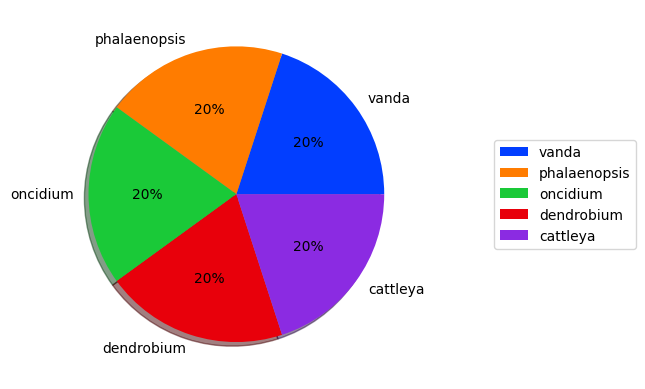

In [13]:
data = [len(vanda_files), len(phalaenopsis_files), len(oncidium_files),len(dendrobium_files),len(cattleya_files)]
keys = ['vanda', 'phalaenopsis', 'oncidium', 'dendrobium','cattleya']

# define Seaborn color palette to use
palette_color = sns.color_palette('bright')

# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,autopct='%.0f%%', shadow=True)
plt.legend(loc='center right',  bbox_to_anchor=(1.6, 0.5))

# displaying chart
plt.show()

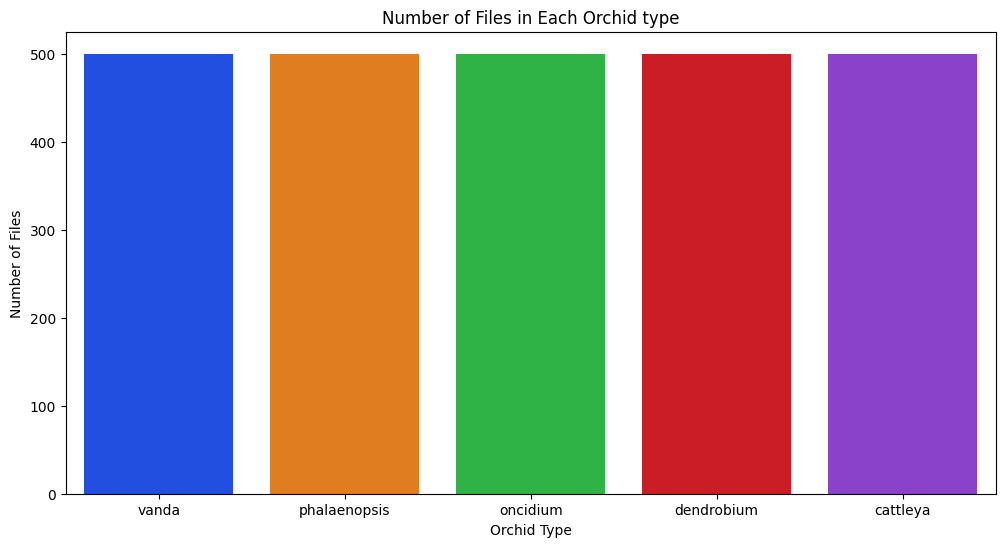

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=data, palette=palette_color)
plt.title('Number of Files in Each Orchid type')
plt.xlabel('Orchid Type')
plt.ylabel('Number of Files')
plt.show()

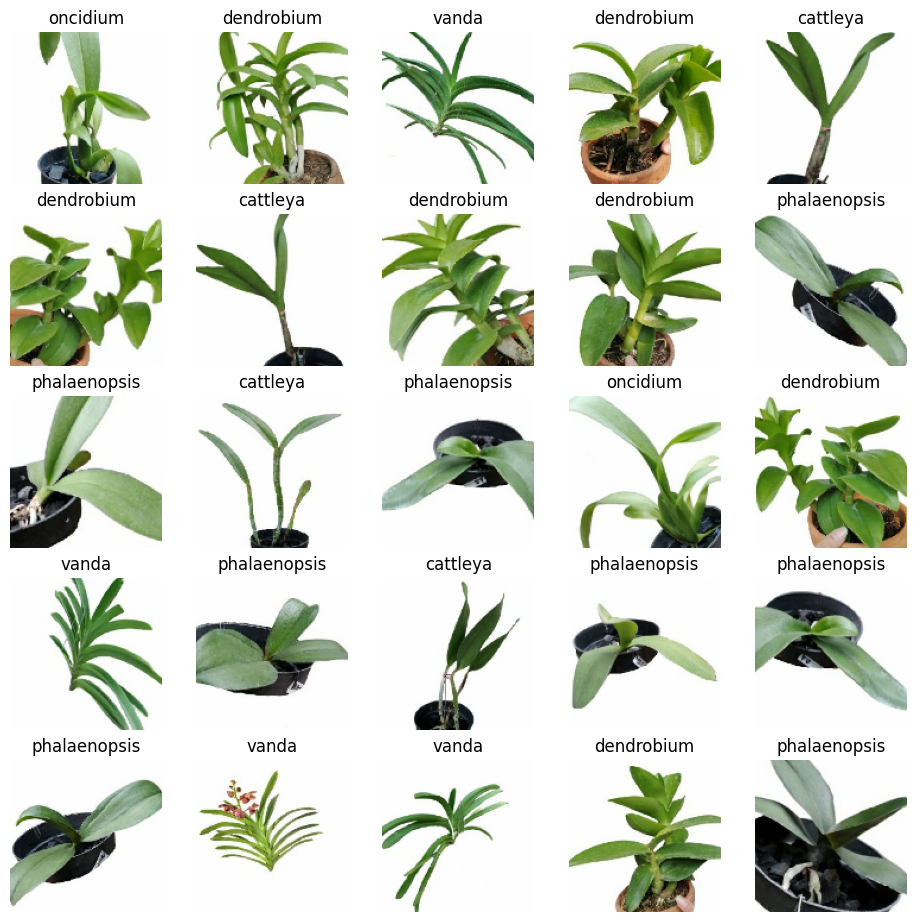

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

nrows = 5 
ncols = 5 
hspace = 0
wspace = 0
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))    
fig.subplots_adjust(hspace, wspace)

for i in range(nrows):
    for j in range(ncols):
        temp = i*ncols+j                # Index looping
        ax[i,j].imshow(X_train[temp])   # Show Features/images
        if y_train[temp] == 0:
            judul = "cattleya"
        elif y_train[temp] == 1:
            judul = "dendrobium"
        elif y_train[temp] == 2:
            judul = "oncidium"
        elif y_train[temp] == 3:
            judul = "phalaenopsis"
        elif y_train[temp] == 4:
            judul = "vanda"
        ax[i,j].set_title(judul)        # Show Labels
        ax[i,j].axis('off')             # Hide axis
plt.show()

In [16]:
from keras.utils import to_categorical

print("Array of y_train :", y_train)
print("Array of y_test  :", y_test)

# One Hot Encode target values
y_train_encode = to_categorical(y_train)
y_test_encode  = to_categorical(y_test)

print("\nArray of y_train_encode :\n\n", y_train_encode)
print("\nArray of y_test_encode :\n\n", y_test_encode)

Array of y_train : [2 1 4 ... 0 1 2]
Array of y_test  : [0 0 0 ... 4 4 4]

Array of y_train_encode :

 [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]

Array of y_test_encode :

 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [17]:
print("X_train_norm     :", X_train_norm.shape)
print("y_train_encode   :", y_train_encode.shape)
print("X_test_norm      :", X_test_norm.shape)
print("y_test_encode    :", y_test_encode.shape)

X_train_norm     : (4000, 128, 128, 3)
y_train_encode   : (4000, 5)
X_test_norm      : (2500, 128, 128, 3)
y_test_encode    : (2500, 5)


In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [19]:
train_dataset=train_datagen.flow_from_directory(directory=path_train,
                              target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 3200 images belonging to 5 classes.


In [20]:
valid_dataset=valid_datagen.flow_from_directory(directory=path_train,
                              target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   batch_size = 64)

Found 800 images belonging to 5 classes.


In [21]:
test_dataset = test_datagen.flow_from_directory(directory = path_test,
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 2500 images belonging to 5 classes.


In [22]:
image_shape=(128,128,3)

In [23]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [24]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [25]:
#cnn model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=METRICS)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=4, mode='min')

In [28]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

In [29]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs =10, callbacks=[es])

Epoch 1/10
50/50 [==============================] - 35s 673ms/step - loss: 1.3677 - accuracy: 0.8145 - precision: 0.6589 - recall: 0.1503 - auc: 0.7434 - f1_score: 0.1941 - val_loss: 0.8357 - val_accuracy: 0.8497 - val_precision: 0.6812 - val_recall: 0.4675 - val_auc: 0.9105 - val_f1_score: 0.5472
Epoch 2/10
50/50 [==============================] - 30s 600ms/step - loss: 0.6215 - accuracy: 0.9087 - precision: 0.8234 - recall: 0.6922 - auc: 0.9510 - f1_score: 0.7472 - val_loss: 0.2498 - val_accuracy: 0.9680 - val_precision: 0.9275 - val_recall: 0.9112 - val_auc: 0.9921 - val_f1_score: 0.9187
Epoch 3/10
50/50 [==============================] - 30s 592ms/step - loss: 0.3997 - accuracy: 0.9404 - precision: 0.8680 - recall: 0.8281 - auc: 0.9784 - f1_score: 0.8475 - val_loss: 0.4344 - val_accuracy: 0.9413 - val_precision: 0.8722 - val_recall: 0.8275 - val_auc: 0.9751 - val_f1_score: 0.8494
Epoch 4/10
50/50 [==============================] - 30s 594ms/step - loss: 0.3435 - accuracy: 0.9522 - 

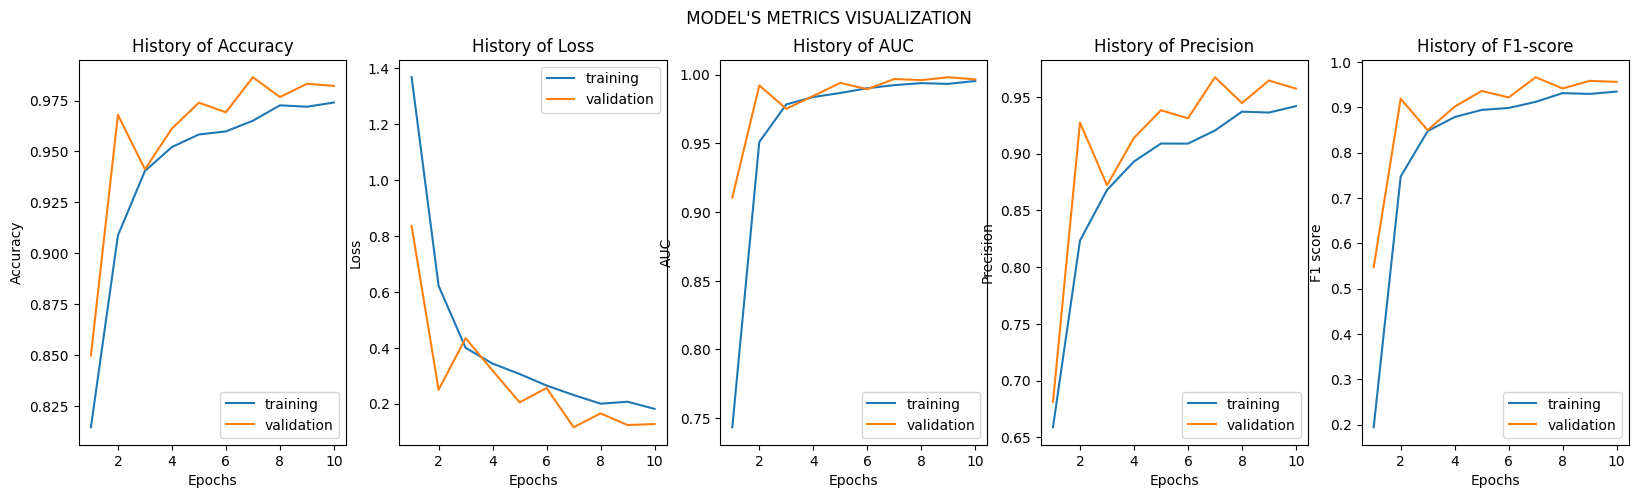

In [30]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [31]:
from tensorflow.keras.applications.vgg16 import VGG16

In [32]:

vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False
   
x = keras.layers.Flatten()(vgg16.output)

prediction = keras.layers.Dense(5, activation='softmax')(x)

model2 = keras.Model(inputs=vgg16.input, outputs=prediction)

In [33]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [34]:
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=METRICS)

In [35]:
history2=model2.fit(train_dataset,validation_data=valid_dataset,epochs =10, callbacks=[es])

Epoch 1/10
50/50 [==============================] - 221s 4s/step - loss: 0.4697 - accuracy: 0.9481 - precision: 0.9474 - recall: 0.7837 - auc: 0.9841 - f1_score: 0.7996 - val_loss: 0.1372 - val_accuracy: 0.9815 - val_precision: 0.9560 - val_recall: 0.9513 - val_auc: 0.9985 - val_f1_score: 0.9536
Epoch 2/10
50/50 [==============================] - 171s 3s/step - loss: 0.1460 - accuracy: 0.9844 - precision: 0.9706 - recall: 0.9506 - auc: 0.9984 - f1_score: 0.9605 - val_loss: 0.0707 - val_accuracy: 0.9923 - val_precision: 0.9836 - val_recall: 0.9775 - val_auc: 0.9998 - val_f1_score: 0.9801
Epoch 3/10
50/50 [==============================] - 169s 3s/step - loss: 0.0979 - accuracy: 0.9909 - precision: 0.9838 - recall: 0.9706 - auc: 0.9995 - f1_score: 0.9771 - val_loss: 0.0488 - val_accuracy: 0.9965 - val_precision: 0.9925 - val_recall: 0.9900 - val_auc: 0.9999 - val_f1_score: 0.9910
Epoch 4/10
50/50 [==============================] - 167s 3s/step - loss: 0.0783 - accuracy: 0.9915 - precisio

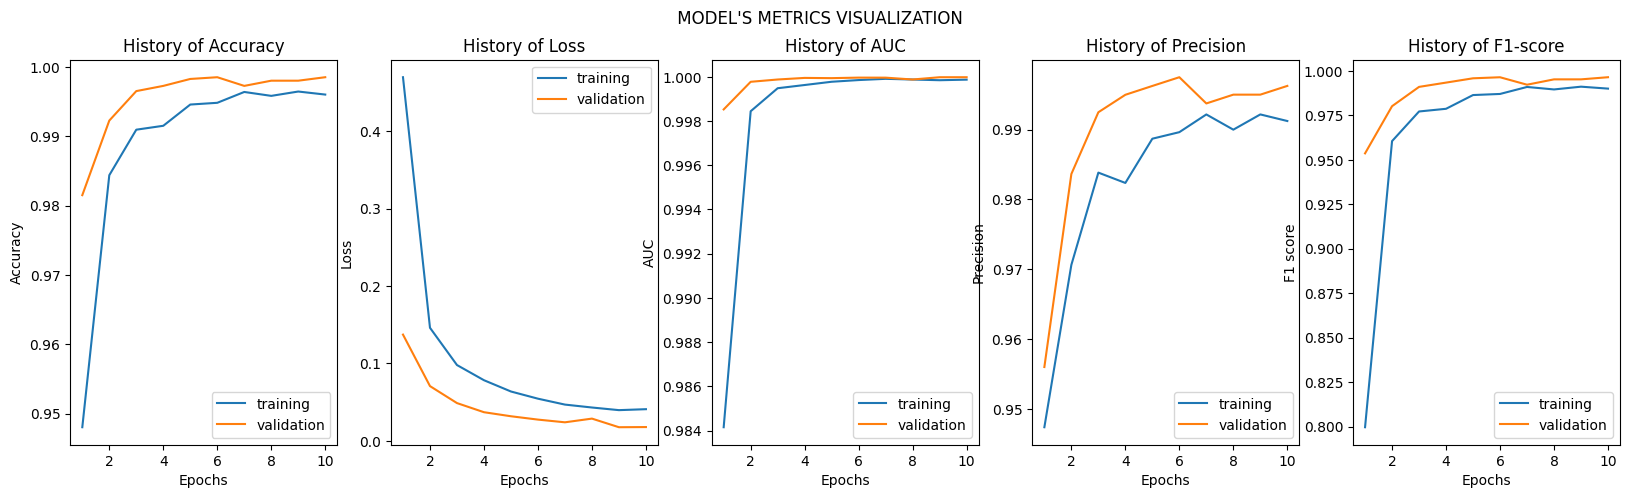

In [36]:
Train_Val_Plot(history2.history['accuracy'],history2.history['val_accuracy'],
               history2.history['loss'],history2.history['val_loss'],
               history2.history['auc'],history2.history['val_auc'],
               history2.history['precision'],history2.history['val_precision'],
               history2.history['f1_score'],history2.history['val_f1_score']
              )

In [37]:
from tensorflow.keras.applications.resnet import ResNet50

In [38]:
resnet50 = ResNet50(input_shape=(128,128,3), weights='imagenet', include_top=False)

for layer in resnet50.layers[:-4]:
    layer.trainable=False
    
x = keras.layers.Flatten()(resnet50.output)

prediction = keras.layers.Dense(5, activation='softmax')(x)

model3 = keras.Model(inputs=resnet50.input, outputs=prediction)

In [39]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [40]:
model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=METRICS)

In [41]:
history3=model3.fit(train_dataset,validation_data=valid_dataset,epochs =10, callbacks=[es])

Epoch 1/10
50/50 [==============================] - 71s 1s/step - loss: 1.1853 - accuracy: 0.8974 - precision: 0.7665 - recall: 0.7007 - auc: 0.9238 - f1_score: 0.6569 - val_loss: 1.1522 - val_accuracy: 0.8338 - val_precision: 0.7129 - val_recall: 0.2825 - val_auc: 0.8335 - val_f1_score: 0.4008
Epoch 2/10
50/50 [==============================] - 63s 1s/step - loss: 0.5772 - accuracy: 0.9103 - precision: 0.7998 - recall: 0.7353 - auc: 0.9572 - f1_score: 0.7662 - val_loss: 1.0526 - val_accuracy: 0.8698 - val_precision: 0.8681 - val_recall: 0.4112 - val_auc: 0.8619 - val_f1_score: 0.5518
Epoch 3/10
50/50 [==============================] - 64s 1s/step - loss: 0.4934 - accuracy: 0.9265 - precision: 0.8376 - recall: 0.7847 - auc: 0.9681 - f1_score: 0.8102 - val_loss: 0.8115 - val_accuracy: 0.8955 - val_precision: 0.8248 - val_recall: 0.6062 - val_auc: 0.9205 - val_f1_score: 0.6933
Epoch 4/10
50/50 [==============================] - 64s 1s/step - loss: 0.4622 - accuracy: 0.9308 - precision: 0

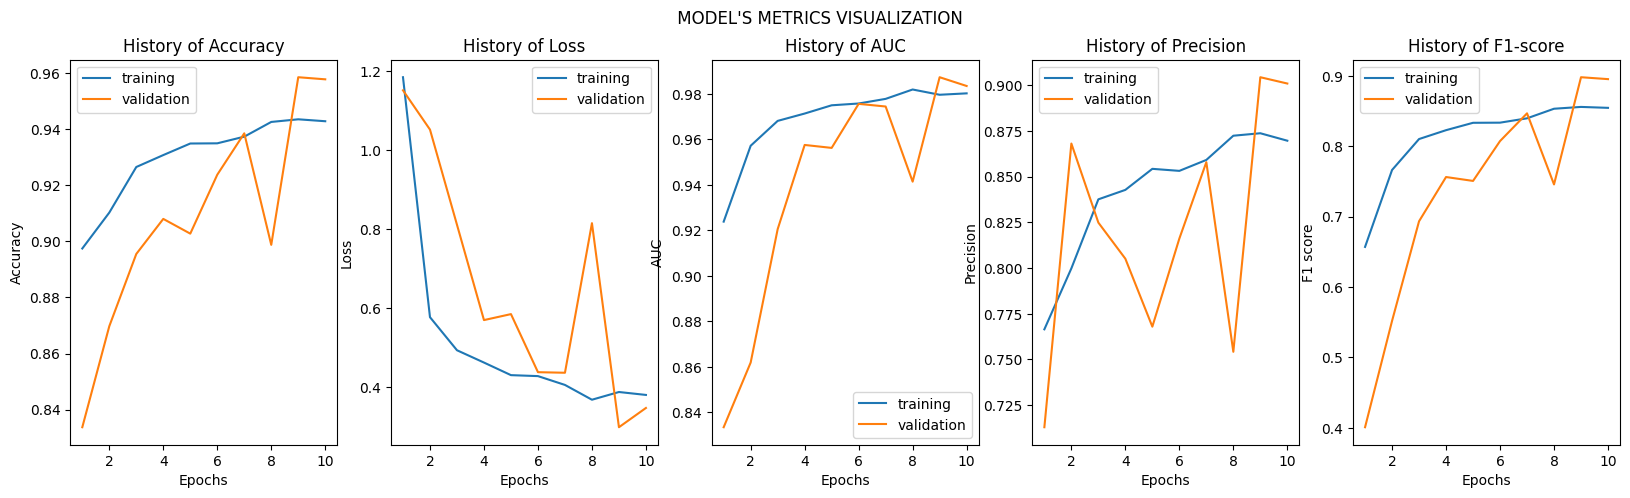

In [42]:
Train_Val_Plot(history3.history['accuracy'],history3.history['val_accuracy'],
               history3.history['loss'],history3.history['val_loss'],
               history3.history['auc'],history3.history['val_auc'],
               history3.history['precision'],history3.history['val_precision'],
               history3.history['f1_score'],history3.history['val_f1_score']
              )

In [43]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [44]:
inceptionv3 = InceptionV3(input_shape=(128,128,3), weights='imagenet', include_top=False)

for layer in inceptionv3.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(inceptionv3.output)

prediction = keras.layers.Dense(5, activation='softmax')(x)

model4 = keras.Model(inputs=inceptionv3.input, outputs=prediction)

In [45]:
model4.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=METRICS)
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                            

In [85]:
history4=model4.fit(train_dataset,validation_data=valid_dataset,epochs =10, callbacks=[es])

Epoch 1/10
50/50 [==============================] - 49s 870ms/step - loss: 1.3086 - accuracy: 0.8971 - precision: 0.7537 - recall: 0.7215 - auc: 0.9200 - f1_score: 0.7191 - val_loss: 0.3194 - val_accuracy: 0.9565 - val_precision: 0.9003 - val_recall: 0.8800 - val_auc: 0.9846 - val_f1_score: 0.8895
Epoch 2/10
50/50 [==============================] - 43s 856ms/step - loss: 0.2875 - accuracy: 0.9616 - precision: 0.9107 - recall: 0.8959 - auc: 0.9877 - f1_score: 0.9033 - val_loss: 0.2610 - val_accuracy: 0.9697 - val_precision: 0.9325 - val_recall: 0.9150 - val_auc: 0.9887 - val_f1_score: 0.9251
Epoch 3/10
50/50 [==============================] - 46s 921ms/step - loss: 0.2748 - accuracy: 0.9632 - precision: 0.9141 - recall: 0.9006 - auc: 0.9882 - f1_score: 0.9072 - val_loss: 0.1426 - val_accuracy: 0.9793 - val_precision: 0.9532 - val_recall: 0.9425 - val_auc: 0.9962 - val_f1_score: 0.9498
Epoch 4/10
50/50 [==============================] - 51s 1s/step - loss: 0.2285 - accuracy: 0.9711 - pre

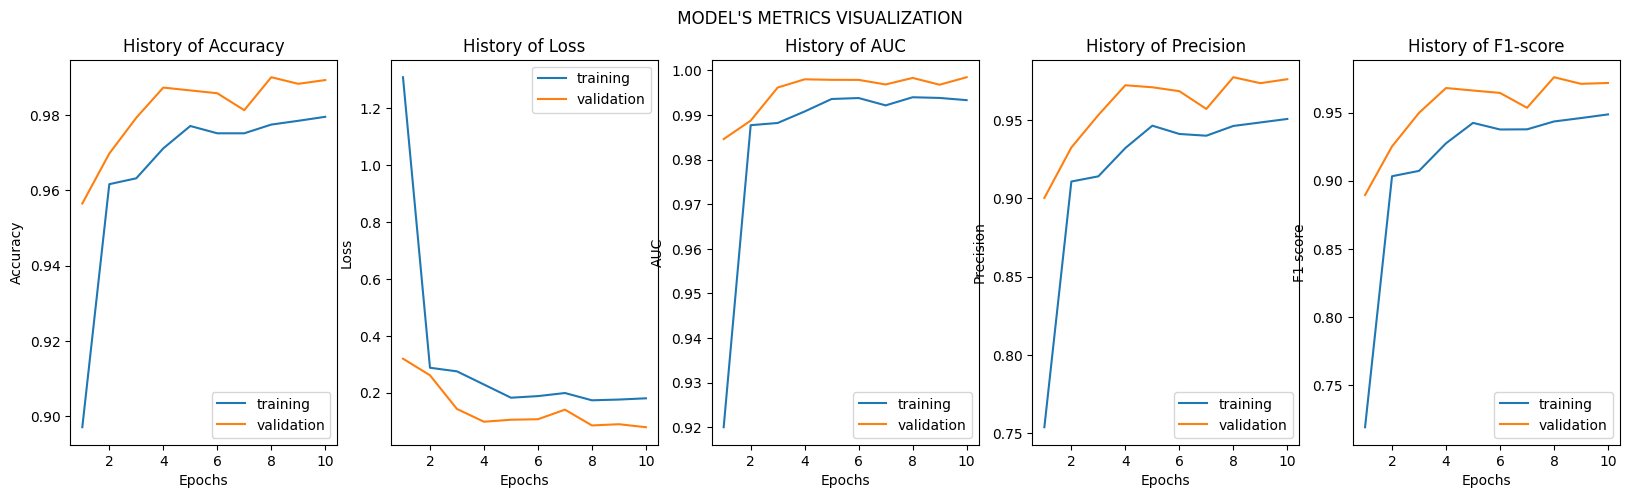

In [86]:
Train_Val_Plot(history4.history['accuracy'],history4.history['val_accuracy'],
               history4.history['loss'],history4.history['val_loss'],
               history4.history['auc'],history4.history['val_auc'],
               history4.history['precision'],history4.history['val_precision'],
               history4.history['f1_score'],history4.history['val_f1_score']
              )